In [1]:
import numpy as np
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt

np.__version__, matplotlib.__version__

('1.26.4', '3.5.2')

In [2]:
v = 1.0  
ds = 0.01  
T = 100
num_steps = int(T // ds)  
# ts = np.arange(ds, T + 0.001, ds)  # steps in integral
ts = np.arange(1, num_steps) * ds
num_particles = 100  

DR_vals = [0.1, 0.2, 0.5, 0.8, 1.0, 2.0, 3.0, 5.0]

## Q1 Autocorrelation of the direction of motion
__(i)__ The value of correlation as a function of time $t$ can be calculated and visualized as follows:

In [3]:
def compute_integral(phis):
    num_terms = len(phis) - 1
    autocorr = np.zeros(num_terms)
    for i in range(1, num_terms + 1):
        prod = np.cos(phis[:-i]) * np.cos(phis[i:]) + np.sin(phis[:-i]) * np.sin(phis[i:])
        autocorr[i - 1] = np.mean(prod)
    return autocorr

def compute_autocorrelation(DR, num_steps, num_particles):
    avg_autocorr = np.zeros((len(DR), num_steps - 1))
    for row, dr in enumerate(DR):
        for _ in range(num_particles):
            phi = np.zeros(num_steps)
            for i in range(1, num_steps):
                xi = np.sqrt(2 * dr * ds) * np.random.normal()  # noise
                phi[i] = phi[i - 1] + xi
            autocorr_values = compute_integral(phi)
            avg_autocorr[row] += autocorr_values  
    
    avg_autocorr /= num_particles
    return avg_autocorr

avg_autocorr = compute_autocorrelation(DR_vals, num_steps, num_particles)

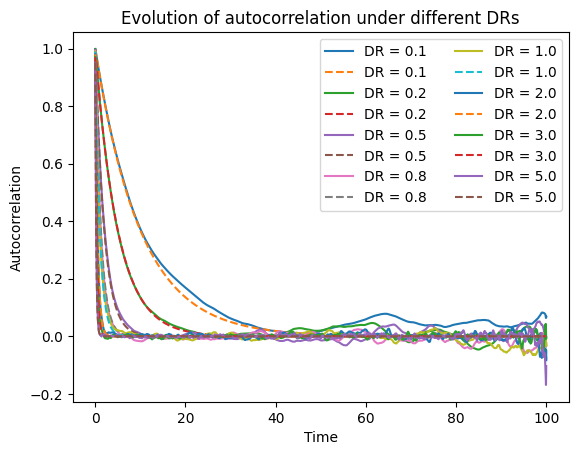

In [4]:
def plot_autocorrelation(DR, ts, avg_autocorr):
    fig = plt.figure()
    f = lambda t, tau_R: np.exp(-t / tau_R)
    for row, dr in enumerate(DR):
        plt.plot(ts, avg_autocorr[row], label=f'DR = {dr}')    # simulation result
        plt.plot(ts, f(ts, 1 / dr), linestyle='--', label=f'DR = {dr}')   # theoretical
    plt.legend(ncol=2)
    plt.title('Evolution of autocorrelation under different DRs')
    plt.xlabel('Time')
    plt.ylabel('Autocorrelation')
    plt.show() 
    
plot_autocorrelation(DR_vals, ts, avg_autocorr)

__(ii)__ The fitted value of $\tau_{R}$ and its theoretical value $\tau_{R} = \frac{1}{D_{R}}$ are calculated and plotted as follows:

In [5]:
def fit_tau_r(DR, avg_autocorr, ts):
    f = lambda t, tau_R: np.exp(-t / tau_R)
    estimated_tau_R = list()
    for row, dr in enumerate(DR):
        popt, _ = opt.curve_fit(f, ts, avg_autocorr[row])
        estimated_tau_R.append(popt[0])
    return estimated_tau_R

estimated_tau_R = fit_tau_r(DR_vals, avg_autocorr, ts)

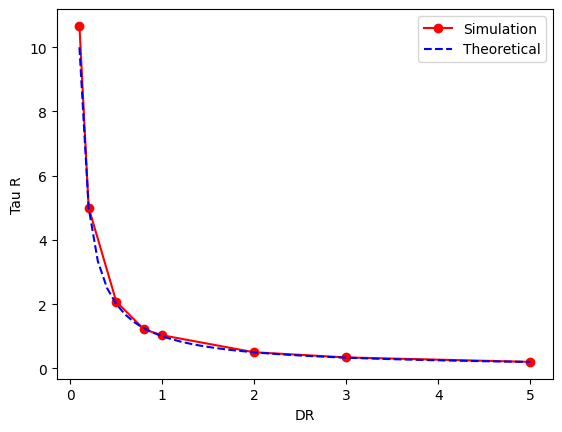

In [6]:
def plot_tau(DR, estimated_tau_R):
    fig = plt.figure()
    xs = np.linspace(min(DR), max(DR), 50)
    ys = 1 / xs
    plt.plot(DR, estimated_tau_R, marker='o', label='Simulation', color='red')    # simulation result
    plt.plot(xs, ys, linestyle='--', label='Theoretical', color='b')   # theoretical
    plt.legend()
    plt.xlabel('DR')
    plt.ylabel('Tau R')
    plt.show()
    
plot_tau(DR_vals, estimated_tau_R)

## Q2 Effective diffusion coefficient in two dimensions
The theoretical and simulated values of mean square displacement(MSD) are calculated and visualized as follows:

In [7]:
def compute_msd(DR, vs, num_particles, num_steps):
    simulation_msd = np.zeros((len(DR), len(vs), num_steps))
    theoretical_msd = np.zeros((len(DR), len(vs), num_steps))
    for i, dr in enumerate(DR):
        tau = 1 / dr
        for ii, v in enumerate(vs):
            xs = np.zeros((num_particles, num_steps))
            ys = np.zeros((num_particles, num_steps))
            for p in range(num_particles):
                phi = np.zeros(num_steps)
                for t in range(1, num_steps):
                    xi = np.sqrt(2 * dr * ds) * np.random.normal()
                    phi[t] = phi[t - 1] + xi   # random move
                    xs[p, t] = xs[p, t - 1] + v * np.cos(phi[t - 1])  # new position
                    ys[p, t] = ys[p, t - 1] + v * np.sin(phi[t - 1])
            for t in range(1, num_steps):
                simulation_msd[i][ii][t] += np.mean((xs[:, t] - xs[:, 0])**2 + (ys[:, t] - ys[:, 0])**2)
                theoretical_msd[i][ii][t] = 2 * v**2 * tau * t
            
    simulation_msd /= num_particles
    return simulation_msd, theoretical_msd
        
vs = [0.1, 0.5, 1, 2]
simulation_msd, theoretical_msd = compute_msd(DR_vals, vs, num_particles, num_steps)

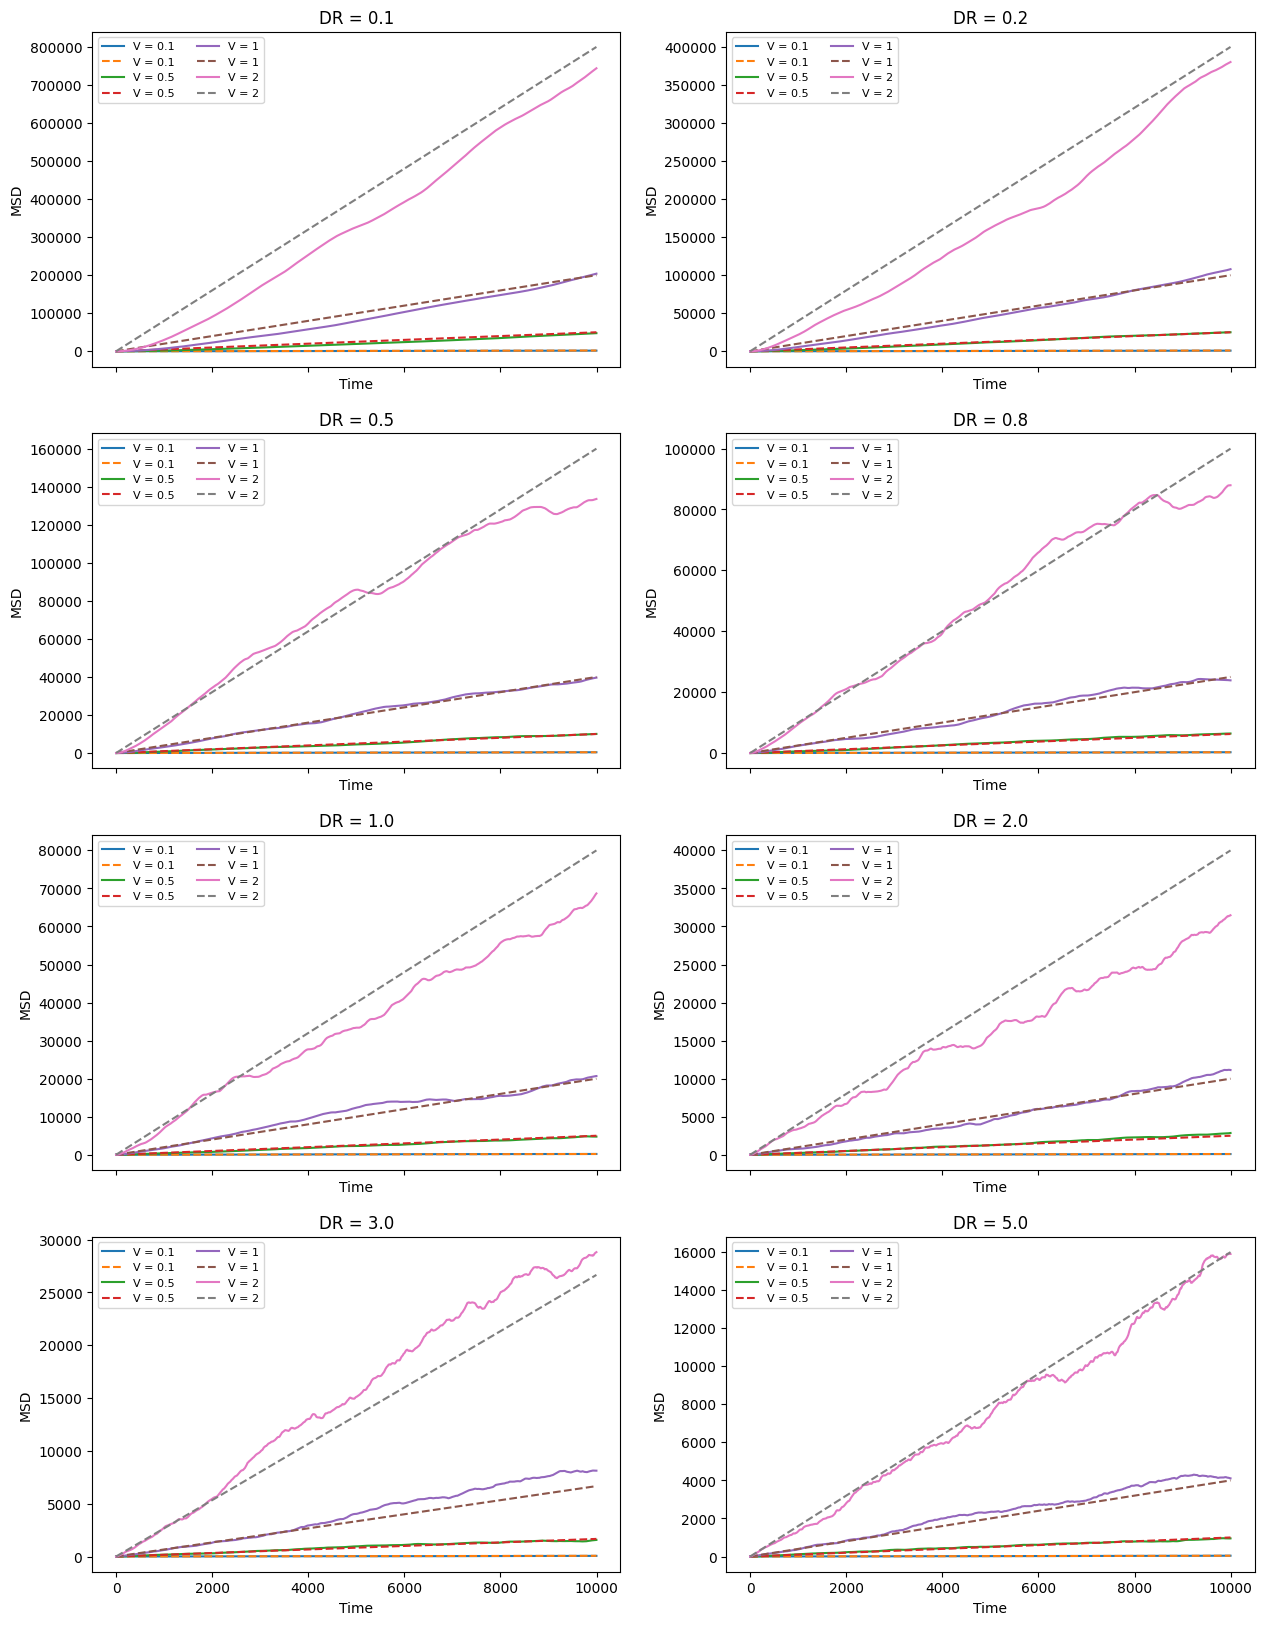

In [10]:
def plot_msd(DR, vs, num_steps):
    num_DR = len(DR)
    fig, axs = plt.subplots(4, 2, figsize=(15, 20), sharex=True) 
    for i, dr in enumerate(DR):
        for ii, v in enumerate(vs):
            axs[i // 2, i % 2].plot(simulation_msd[i][ii], label=f'V = {v}')
            axs[i // 2, i % 2].plot(theoretical_msd[i][ii], linestyle='--',  label=f'V = {v}')
            axs[i // 2, i % 2].legend()
            axs[i // 2, i % 2].set_xlabel('Time')
            axs[i // 2, i % 2].set_ylabel('MSD')
            axs[i // 2, i % 2].set_title(f'DR = {dr}')
            axs[i // 2, i % 2].legend(ncol=2, fontsize=8)
#     fig.suptitle('MSD with different V and DR values')
    
    return

plot_msd(DR_vals, vs, num_steps)